# Exploring Community Engagement with Questions on the 20 Largest StackExchange datasets

### The aim of the project is to explore how the top 20 largest Stack Exchange communities interact with questions. Firstly, I will perform EDA on all questions, answers and comments of the 20 large datasets. The second goal is to build a classification model on various different communities to identify questions with high potential of positive community engagement.

### The classification model will use only the question text and title as input, deriving features using sentiment analysis and LDA. Positive community engagement will be summarised by PCA using the score of the question, the number of answers and the sentiment of the answers.

### I will then test the individual models across all 20 communities to compare results. In this way I should gain insight into the degree to which StackExchange communities engage with questions homogenously.

---

### Load Libraries

In [1]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)

#import graphframes
#from graphframes import *
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql.functions import col, lit, when
from pyspark.sql import Row

from datetime import datetime

import re
import numpy as np

sc.setCheckpointDir("gs://bucket-brad-project/tmp/") # can change this

import nltk
#nltk.download('all') # uncomment this for first run to check that all data has already been installed
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
stop_words = set(stopwords.words('english'))
table = str.maketrans('', '', string.punctuation)
lmtzr = WordNetLemmatizer()

# function to tokenise and lemmatise
def get_tokens(line):
    ###
    import nltk
#     nltk.download('all')
    ###
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuations from each word
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words
    words = [w for w in words if not w in stop_words]
    # lemmatizing the words, see https://en.wikipedia.org/wiki/Lemmatisation
    words = [lmtzr.lemmatize(w) for w in words]
    return (words)

# check default number of partitions
sc.defaultParallelism

4

In [2]:
# choose datasets to compare
data_array = [
"expatriates",
"elementaryos",
"lifehacks",
"literature",
"opendata",
"tor",
"patents",
"ham",
"hsm",
"latin",
"martialarts",
"opensource",
"woodworking"
]

In [3]:
# point to right directory
fpath = 'gs://bucket-brad-project/datasets/'

# function to extract data from xml files
dfs = {}
def load_all_xml(table_name):
    xml_name = table_name.capitalize()
    for i in data_array:
        table = sqlContext.read.format('com.databricks.spark.xml').options(rowTag=table_name).load(fpath+i+'.stackexchange.com/'+xml_name+'.xml')
        rdd_table = table.rdd.flatMap(lambda x: x).flatMap(lambda x: x)
        dfs[i] = sqlContext.createDataFrame(rdd_table, table.schema.fields[0].dataType.elementType)
        dfs[i].createOrReplaceTempView(table_name)
    return dfs

In [4]:
# extract all datasets
posts_dfs = load_all_xml("posts")

In [5]:
# print type of posts_dfs
print(type(posts_dfs))
print('\n')

# print type of first dataframe
print(type(posts_dfs["expatriates"]))
print('\n')

# schema of first dataframe
posts_dfs["expatriates"].printSchema()

<class 'dict'>


<class 'pyspark.sql.dataframe.DataFrame'>


root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _LastActivityDate: string (nullable = true)
 |-- _LastEditDate: string (nullable = true)
 |-- _LastEditorDisplayName: string (nullable = true)
 |-- _LastEditorUserId: long (nullable = true)
 |-- _OwnerDisplayName: string (nullable = true)
 |-- _OwnerUserId: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: long (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _VALUE: string (nullable = true)
 |-- _ViewCount: long (nullable = 

# EDA

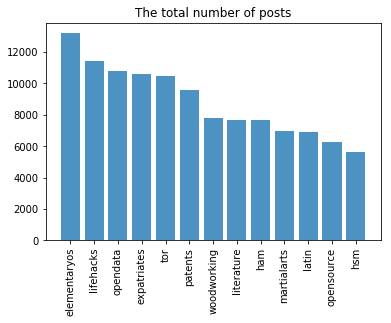

In [6]:
# total number of posts of dataframes
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].count()

# bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('The total number of posts')
plt.show()

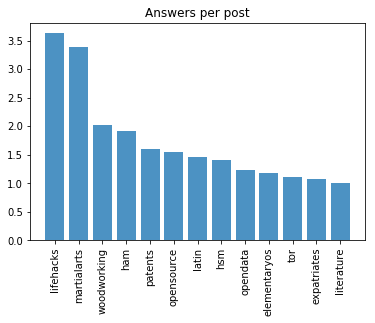

In [7]:
# average number of answers per post across dataframes
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_AnswerCount').collect()[0][0]

# bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Answers per post')
plt.show()

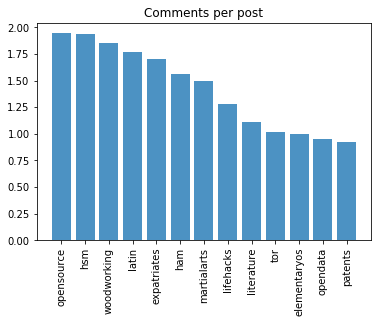

In [8]:
# average number of comments per post across dataframes
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_CommentCount').collect()[0][0]

# bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Comments per post')
plt.show()

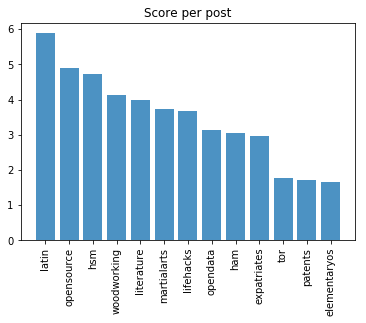

In [9]:
# average number of score per post across dataframes
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_Score').collect()[0][0]

# bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Score per post')
plt.show()

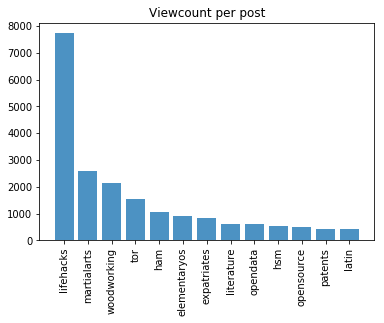

In [10]:
# average number of viewcount per post across dataframes
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().avg('_ViewCount').collect()[0][0]

# bar plot of post counts in descending order
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Viewcount per post')
plt.show()

In [58]:
plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].select('_ViewCount').rdd.flatMap(lambda x: x).collect()
    plot_data[i] = [x for x in plot_data[i] if x is not None]

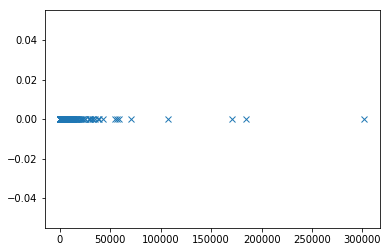

In [66]:
# 1D plot of expat viewcount
val = 0.
ar = plot_data['expatriates']
plt.plot(ar, np.zeros_like(ar) + val, 'x')
plt.show()

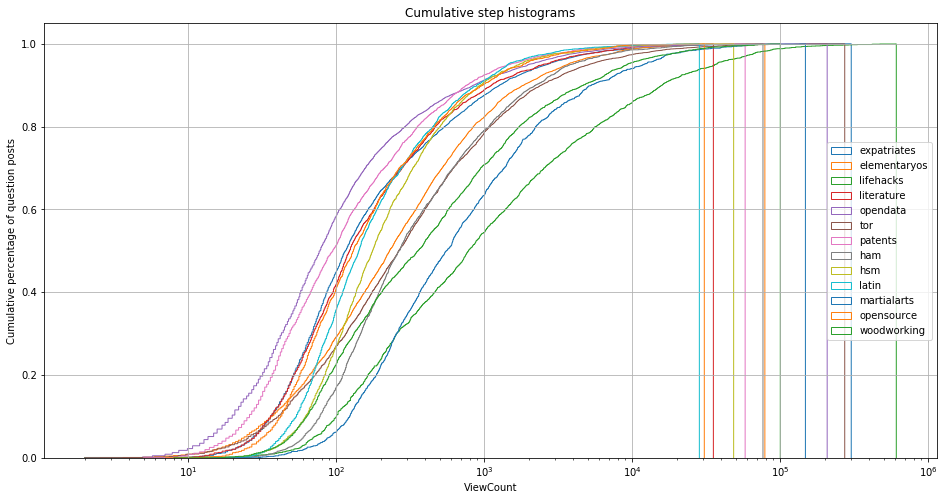

In [67]:
# cumulative distribution of viewcount
n_bins = 500000
fig, ax = plt.subplots(figsize=(16, 8))
for i in data_array:
    n, bins, patches = ax.hist(plot_data[i], n_bins, density=True, histtype='step',
                               cumulative=True, label=i)
ax.grid(True)
ax.set_xscale('log')
ax.legend(loc='right')
ax.set_title('Cumulative step histograms')
ax.set_xlabel('ViewCount')
ax.set_ylabel('Cumulative percentage of question posts')

plt.show()

### ! Problem plotting length of questions !

plot_data = {}
for i in data_array:
    plot_data[i] = posts_dfs[i].groupBy().length('_Body').collect()[0][0]

# bar plot
import operator
plot_list = sorted(plot_data.items(), key=operator.itemgetter(1), reverse=True)
x, y = zip(*plot_list) # unpack a list of pairs into two tuples
plt.bar(x, y, align='center', alpha=.8)
plt.xticks(range(len(plot_list)), list([i[0] for i in plot_list]), rotation=90)
plt.title('Viewcount per post')
plt.show()

## average length of post across fora

posts_dfs["expatriates"].select('_Body').rdd.flatMap(lambda x: x).flatMap(lambda x: x).collect()

len(posts_dfs['expatriates'].select('_Body').take(1)[0][0])

len(posts_dfs['expatriates'].select('_Body').take(2)[1][0])

posts_dfs['expatriates'].select('_Body').take(1)[0][0]

posts_dfs['expatriates'].select('_Body').take(2)[1][0]

spark.createDataFrame([('ABC ',)], ['a']).select(length('a').alias('length')).collect()

# Working with Body Text

In [6]:
body_data = {}
for i in data_array:
    body_data[i] = posts_dfs[i].select("_Body").rdd.flatMap(lambda r: r)

In [7]:
body_data['expatriates'].take(1)

["<p>I have a Dutch passport and Dutch driving license, and I have recently moved to Canada (Ontario).  Government instructions on transferring driving licenses all seem to assume that new residents will own a car.  I will not own a car, but may occasionally drive in cars I don't own, such as rental cars.  From the rental company point of view, my Dutch driving license is sufficient.  I don't know if the same is true from  the government's perspective.</p>\n\n<p>If I do not own a car, will I need to transfer my foreign driving license to an Ontario one?</p>\n"]

### Tokenise and lemmatise

In [38]:
body_rdd = {}
for i in data_array:
    body_rdd[i] = body_data[i].map(lambda line: (1, get_tokens(line)))

In [39]:
body_rdd['expatriates'].take(1)[0][1][:10]

['p',
 'dutch',
 'passport',
 'dutch',
 'driving',
 'license',
 'recently',
 'moved',
 'canada',
 'ontario']

In [40]:
### WHAT IF DIFFERENT THRESHOLDS ??? NEED number of tokens per fora

doc_stop_words = {}
for i in data_array:
    doc_stop_words[i] = body_rdd[i].flatMap(lambda r: r[1]).map(lambda r: (r,1)).reduceByKey(lambda a,b: a+b)
    # here we assume that words that appear very frequently are stop words. We use 3000 as a threshold.
    doc_stop_words[i] = doc_stop_words[i].filter(lambda a: a[1]>3000).map(lambda r: r[0]).collect()
    body_rdd[i] = body_rdd[i].map(lambda r: (r[0],[w for w in r[1] if not w in doc_stop_words[i] and not len(w)==1]))

In [43]:
body_rdd['expatriates'].collect()

[(1,
  ['dutch',
   'passport',
   'dutch',
   'driving',
   'license',
   'recently',
   'moved',
   'canada',
   'ontario',
   'government',
   'instruction',
   'transferring',
   'driving',
   'license',
   'seem',
   'assume',
   'new',
   'resident',
   'car',
   'car',
   'may',
   'occasionally',
   'drive',
   'car',
   'rental',
   'car',
   'rental',
   'company',
   'point',
   'view',
   'dutch',
   'driving',
   'license',
   'sufficient',
   'know',
   'true',
   'government',
   'perspective',
   'car',
   'transfer',
   'foreign',
   'driving',
   'license',
   'ontario']),
 (1,
  ['temporary',
   'resident',
   'ontario',
   'three',
   'year',
   'work',
   'permit',
   'applying',
   'credit',
   'card',
   'told',
   'required',
   'wwwontariocagovernmentontariophotocard',
   'ontario',
   'photo',
   'card',
   'get',
   'card',
   'temporarily',
   'canada',
   'work',
   'permit']),
 (1,
  ['citizen',
   'according',
   'government',
   'dolgov',
   'website',
 

### Convert tokens into sparse vectors

In [44]:
from pyspark.ml.feature import CountVectorizer
from pyspark.sql.functions import monotonically_increasing_id

body_df = {}
for i in data_array:
    body_df[i] = spark.createDataFrame(body_rdd[i], ["dummy","words"])
    body_df[i].cache()

body_df['expatriates'].take(1)

[Row(dummy=1, words=['dutch', 'passport', 'dutch', 'driving', 'license', 'recently', 'moved', 'canada', 'ontario', 'government', 'instruction', 'transferring', 'driving', 'license', 'seem', 'assume', 'new', 'resident', 'car', 'car', 'may', 'occasionally', 'drive', 'car', 'rental', 'car', 'rental', 'company', 'point', 'view', 'dutch', 'driving', 'license', 'sufficient', 'know', 'true', 'government', 'perspective', 'car', 'transfer', 'foreign', 'driving', 'license', 'ontario'])]

### Now, we generate vectors that are histograms of word counts associated with each message

In [46]:
cntvcr = CountVectorizer(inputCol="words", outputCol="features", minDF=2)

cntvcr_models = {}
word_feat_list = {}
for i in data_array:
    cntvcr_models[i] = cntvcr.fit(body_df[i])
    word_feat_list[i] = cntvcr_models[i].transform(body_df[i])
    word_feat_list[i].cache()
    
word_feat_list['expatriates'].show(10)

+-----+--------------------+--------------------+
|dummy|               words|            features|
+-----+--------------------+--------------------+
|    1|[dutch, passport,...|(12097,[4,6,11,15...|
|    1|[temporary, resid...|(12097,[0,1,18,78...|
|    1|[according, gover...|(12097,[31,38,41,...|
|    1|[european, either...|(12097,[1,4,10,46...|
|    1|[mexican, tempora...|(12097,[11,23,26,...|
|    1|[multi, national,...|(12097,[1,2,4,20,...|
|    1|[irish, looking, ...|(12097,[12,15,25,...|
|    1|[usually, leasing...|(12097,[32,39,45,...|
|    1|[ol, brand, speci...|(12097,[11,15,18,...|
|    1|[driving, license...|(12097,[18,60,63,...|
+-----+--------------------+--------------------+
only showing top 10 rows



### Convert pyspark.ml vectors to pyspark.mllib vectors

In [47]:
from pyspark.mllib.linalg import Vectors
#from pyspark.ml import linalg as ml_linalg
def as_mllib_vector(v):
    return Vectors.sparse(v.size, v.indices, v.values)

features = {}
feature_vec_list = {}
for i in data_array:
    features[i] = word_feat_list[i].select("features")
    feature_vec_list[i] = features[i].rdd.map(lambda r: as_mllib_vector(r[0]))
    feature_vec_list[i].cache()

feature_vec_list['expatriates'].take(1)

[SparseVector(12097, {4: 1.0, 6: 1.0, 11: 1.0, 15: 1.0, 18: 1.0, 22: 1.0, 60: 4.0, 78: 1.0, 82: 1.0, 97: 5.0, 113: 1.0, 140: 3.0, 169: 2.0, 195: 4.0, 299: 1.0, 328: 1.0, 356: 1.0, 365: 1.0, 437: 1.0, 520: 1.0, 574: 2.0, 576: 1.0, 577: 1.0, 883: 1.0, 1184: 1.0, 1538: 2.0, 2114: 1.0, 2215: 1.0, 2645: 1.0})]

### Take a look at the vocabulary

In [48]:
print ("Vocabulary from CountVectorizerModel is:\n")
print(cntvcr_models['expatriates'].vocabulary[:100])
print("\n---\n")

M = len(cntvcr_models['expatriates'].vocabulary)
print("Number of terms M = ", M)

Vocabulary from CountVectorizerModel is:

['permit', 'card', 'residence', 'application', 'passport', 'eu', 'may', 'question', 'citizenship', 'job', 'like', 'company', 'want', 'state', 'case', 'know', 'day', 'family', 'resident', 'germany', 'document', 'could', 'new', 'status', 'even', 'go', 'pay', 'stay', 'might', 'however', 'working', 'find', 'take', 'right', 'living', 'make', 'since', 'still', 'must', 'able', 'first', 'live', 'employer', 'bank', 'back', 'without', 'insurance', 'child', 'way', 'france', 'people', 'income', 'another', 'immigration', 'use', 'long', 'law', 'form', 'possible', 'requirement', 'license', 'national', 'german', 'permanent', 'account', 'student', 'process', 'information', 'ol', 'two', 'person', 'mean', 'wife', 'french', 'british', 'home', 'say', 'thing', 'canada', 'leave', 'date', 'valid', 'foreign', 'certificate', 'answer', 'travel', 'move', 'number', 'period', 'rule', 'much', 'see', 'good', 'born', 'enter', 'whether', 'spouse', 'car', 'address', 'de']

---



###  Latent Semantic Analysis

In [49]:
from pyspark.mllib.linalg.distributed import RowMatrix

feature_mat_list = {}
for i in data_array:
    feature_mat_list[i] = RowMatrix(feature_vec_list[i])

# Here we use the dimension of latent factors to be k
k = 5
feature_svd_list = {}
U_list = {}
s_list = {}
V_list = {}
for i in data_array:
    feature_svd_list[i] = feature_mat_list[i].computeSVD(5, computeU=True)
    U_list[i] = feature_svd_list[i].U       # The U factor is a RowMatrix.
    s_list[i] = feature_svd_list[i].s       # The singular values are stored in a local dense vector.
    V_list[i] = feature_svd_list[i].V       # The V factor is a local dense matrix.

In [51]:
print("number of rows of U", U_list['expatriates'].numRows()) # this is the number of documents (N)
print("number of rows of V", V_list['expatriates'].numRows ) # this is the number of terms (M)

number of rows of U 10578
number of rows of V 12097


In [53]:
collected = U_list['expatriates'].rows.take(10)

print("U factors for expatriate forum are:")
for vector in collected:
    print(vector)
    
print("Singular values are: \n", s_list['expatriates'])

print("V factors are: \n", V_list['expatriates'])

U factors for expatriate forum are:
[-0.00606825295216643,0.0009779281057787613,-0.009981616828006124,0.008236417008592402,0.008304591277039105]
[-0.003979376078839321,0.004644076574844579,0.007608981245828249,0.00032831767273607703,-0.006029798721088493]
[-0.0037104062002551595,0.003162181538168792,-0.00431669178172915,0.003862181302481146,0.009086006094995658]
[-0.0030657170868433592,0.0009258583653735746,0.0006161113846400769,-0.0005736835482129341,-0.0006012006500307119]
[-0.0019125744582833126,0.0030364078741293293,-0.0032754781897493443,0.00240116621471595,0.0013104782330373287]
[-0.005012705974270818,-0.003420517834052062,0.004132978977408907,-0.00615743759173299,-0.007242268084634106]
[-0.005515726867370669,0.0019733699322400694,-0.004436569952809016,-0.0023560869903104303,0.0009917106071284177]
[-0.0024842126439376484,0.0034137630225091467,-0.003362866912918554,0.001165288952569228,-0.0002226150863346897]
[-0.005458828216736846,0.004254671239305027,-0.0054880564849266195,0.001

### Plot

In [54]:
from sklearn.manifold import TSNE

collected_list = {}
Uarray_list = {}
Uembedded_list = {}

for i in data_array:
    collected_list[i] = U_list[i].rows.collect()
    Uarray_list[i] = np.array([[x[i] for i in range(k)] for x in collected_list[i]]) # unpack strange spark vectors
    t_sne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='random')
    Uembedded_list[i] = t_sne_model.fit_transform(Uarray_list[i])

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 10578 samples in 0.005s...
[t-SNE] Computed neighbors for 10578 samples in 0.568s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10578
[t-SNE] Computed conditional probabilities for sample 2000 / 10578
[t-SNE] Computed conditional probabilities for sample 3000 / 10578
[t-SNE] Computed conditional probabilities for sample 4000 / 10578
[t-SNE] Computed conditional probabilities for sample 5000 / 10578
[t-SNE] Computed conditional probabilities for sample 6000 / 10578
[t-SNE] Computed conditional probabilities for sample 7000 / 10578
[t-SNE] Computed conditional probabilities for sample 8000 / 10578
[t-SNE] Computed conditional probabilities for sample 9000 / 10578
[t-SNE] Computed conditional probabilities for sample 10000 / 10578
[t-SNE] Computed conditional probabilities for sample 10578 / 10578
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 86.037979
[t-SNE] KL 

In [55]:
plt.scatter(Uembedded_list['expatriates'][:,0],Uembedded_list['expatriates'][:,1],alpha=.2)
plt.show()
np.shape(Uembedded_list['expatriates'])

KeyError: 'expatriates'

In [ ]:
plt.scatter(Uarray[:,0],Uarray[:,1],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,0],Uarray[:,3],alpha=.1)
plt.show()
plt.scatter(Uarray[:,1],Uarray[:,2],alpha=.1)
plt.scatter(Uarray[:,1],Uarray[:,3],alpha=.1)
plt.show()

It is not true that few messages account for a large fraction of variability

## Latent Dirichlet Allocation

In [ ]:
from pyspark.ml.clustering import LDA

lda = LDA(k=5, maxIter=5)

lda_model = lda.fit(cntvcr_df_w_features)

In [ ]:
ll = lda_model.logLikelihood(cntvcr_df_w_features)

lp = lda_model.logPerplexity(cntvcr_df_w_features)

print("The lower bound on the log likelihood of the entire corpus: " + str(ll))

print("The upper bound on the perplexity: " + str(lp))

In [ ]:
# describe topics
topics = lda_model.describeTopics(5)

print("The topics described by their top-weighted terms:\n")

topics.show(truncate=False)

# Shows the results
topic_i = topics.select("termIndices").rdd.map(lambda r: r[0]).collect()
for i in topic_i:
    print(np.array(cntvcr_model.vocabulary)[i])